In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt

# Téma: Stavové modely časových řad

V této přednášce nás čeká:
- ETS (error-trend-seasonality) modely jako rozšíření exp. vyhlazování,
- strukturní modely - trochu podobný přístup jako u ETS, ale s vyšší flexibilitou.

## ETS modely
### Vzpomínka na SES

Jednoduché exp. vyhlazování pracuje mezi 2 extrémy:
- **Extrém 1:** všechna budoucí data (predikce) jsou rovna poslední pozorované hodnotě čas. řady $y_T$:

$$
\hat{y}_{T+h|T} = y_T, \qquad h=1,2,\ldots
$$

- **Extrém 2:** všechny budoucí (predikované) hodnoty jsou rovny aritmetickému průměru dosud pozorovaných hodnot:

$$
\hat{y}_{T+h|T} = \frac{1}{T} \sum_{t=1}^T y_t, \qquad h=1,2,\ldots
$$

V komponentní formě jsme pracovali s hladinou - **levelem** $l_t$. Výsledný SES model má tvar:

$$
\begin{alignat}{2}
\text{Forecast eq.}&&\qquad \hat{y}_{t+h|t} &= l_t, \\
\text{Smoothing eq.}&&\qquad l_t &= \alpha y_t + (1 - \alpha) l_{t-1}.
\end{alignat}
$$

Připoměňme:
- $h=1$ vede na jednokrokovou předpověď (včetně interpolací)
- $t=T$ vede na predikce budoucích hodnot za horizontem již existujích dat $T$.

## SES ve formě stavového modelu: ETS(A,N,N)
Přepíšeme-li druhou rovnici do podoby

$$
\begin{aligned}
l_t &= l_{t-1} + \alpha(y_t - l_{t-1}) \\
    &= l_{t-1} + \alpha \varepsilon_{t},
\end{aligned}
$$

kde $\varepsilon_t$ je chyba (reziduum) predikce, můžeme rovněž zapsat aktuální pozorování jako součet předchozí hladiny plus chyba predikce,

$$
y_t = l_{t-1} + \varepsilon_t.
$$

Zřejmě tedy můžeme komponentní model vyjádřit i v podobě **stavového modelu**:

$$
\begin{aligned}
y_t &= l_{t-1} + \varepsilon_t, \\
l_t &= l_{t-1} + \alpha\varepsilon_t,
\end{aligned}
$$

kde $\varepsilon_t$ jsou aditivní a nezávislá, ideálně centrované v nule a s konstantní variancí, tedy iid $\varepsilon_t \sim \mathcal{N}(0, \sigma^2)$. Za povšimnutí stojí, že $\alpha = 0$ vede na náhodnou procházku.

<AxesSubplot:xlabel='datum'>

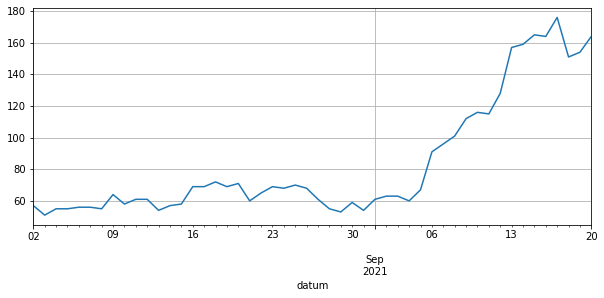

In [4]:
#fn = 'https://onemocneni-aktualne.mzcr.cz/api/v2/covid-19/hospitalizace.csv'
fn = 'data/hospitalizace.csv'
data = pd.read_csv(fn, index_col=0, parse_dates=True, infer_datetime_format=True)
data = data.asfreq('D')
dt = data['pocet_hosp'].last('50D')
dt.plot(figsize=(10,4))

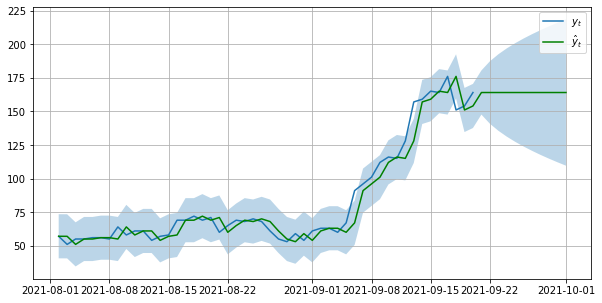

In [30]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
model = ETSModel(dt.astype('float'), error='add', trend=None, damped_trend=False,
                 initialization_method='estimated')
fit = model.fit(disp=True)
preds = fit.get_prediction(end=len(dt)+10)
preds_df = preds.summary_frame()

plt.figure(figsize=(10,5))
plt.plot(dt, label=r'$y_t$')
plt.plot(preds_df['mean'], label=r'$\hat{y}_t$', color='green')
plt.fill_between(preds_df.index, preds_df['pi_lower'],
                preds_df['pi_upper'], alpha=0.3)
plt.legend()
plt.show()

In [31]:
print(fit.summary())

                                 ETS Results                                  
Dep. Variable:             pocet_hosp   No. Observations:                   50
Model:                       ETS(ANN)   Log Likelihood                -177.210
Date:                Tue, 09 Nov 2021   AIC                            360.419
Time:                        10:17:08   BIC                            366.155
Sample:                    08-02-2021   HQIC                           362.604
                         - 09-20-2021   Scale                           70.141
Covariance Type:               approx                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.9999      0.132      7.573      0.000       0.741       1.259
initial_level      57.0304      8.412      6.779      0.000      40.543      73.518
Ljung-Box (Q):                  

## ETS modely obecně

ETS (error - trend - seasonal) modely jsou modely exponenciálního vyhlazování zapsané v podobě **stavových rovnic**. Na základě kombinací komponent rozlišujeme několik základních modelů. Zavedeme-li:
- **E**rror $\in$ {**A**dditive, **M**ultiplicative}
- **T**rend $\in$ {**N**one, **A**dditive, **A**dditive **d**amped}
- **S**easonal $\in$ {**N**one, **A**dditive, **M**ultiplicative}

můžeme definovat modely jako 
- ETS(A,N,N) - jednoduché exponenciální vyhlazování s aditivními chybami, 
- ETS(A,A,N) - Holtova lineární metoda s aditivními chybami,
- ETS(A,A,M) - Holtova-Wintersova multiplikativní metoda
- a spoustu jiných.

Pro modely v podobě stavových rovnic používáme některou z již představených technik odhadu, typicky Kalmanův filtr. Další z výhod ETS modelů oproti metodám exponenciálního vyhlazování je možnost využít informační kritéria (AIC, BIC...) k porovnávání modelů.

Bodové predikce z ETS modelů a z ekvivalentních metod exponenciálního vyhlazování budou z principu vycházet stejně. Výhoda ETS modelů ovšem spočívá v jejich statistickém pohledu na šum. Díky tomu lze kvantifikovat neurčitosti spojené s odhady a predikcemi, což umožňuje vykreslovat i predikční **intervaly spolehlivosti**.

ETS modely mají obecně následující tvar:

$$
\begin{aligned}
x_t &= A(x_{t-1}) + Q(x_{t-1})\varepsilon_t,\\
y_t &= H(x_{t-1}) + R(x_{t-1})\varepsilon_t,
\end{aligned}
$$

kde $x_t = [l_t, b_t, s_{t-1},\ldots,s_{t-m+1}]^\intercal$. V jednodušších modelech je stavový vektor pochopitelně kratší..

Jistou "komplikací" je existence jediné chybové složky $\varepsilon_t$, a to jak ve stavové rovnici, tak v rovnici měření. To vede na určité těžkosti při pokusu použít Kalmanův filtr, na druhé straně je ale MLE odhad poměrně snadný.

## ETS(A,A,N) - dvojité exponenciální vyhlazování

Tato metoda má následující komponentní formu:

$$
\begin{alignat}{2}
\text{Forecast eq.}&&\qquad \hat{y}_{t+h|t} &= l_t + hb_t, \\
\text{Level eq.}&&\qquad l_t &= \alpha y_t + (1 - \alpha)(l_{t-1} + b_{t-1}),\\
\text{Trend eq.}&&\qquad b_t &= \beta^{*}(l_t - l_{t-1}) + (1 - \beta^{*})b_{t-1},
\end{alignat}
$$

kde $l_t$ je level (hladina) časové řady v čase $t$, $b_t$ je odhad směrnice trendu v čase $t$, parametry $\alpha, \beta^* \in [0, 1]$ jsou vyhlazovací paramety. Ve tvaru stavového modelu potom dostáváme

$$
\begin{aligned}
y_t &= l_{t-1} + b_{t-1} + \varepsilon_t, \\
l_t &= l_{t-1} + b_{t-1} + \alpha\varepsilon_t, \\
b_t &= b_{t-1} + \alpha\beta^*\varepsilon_t,
\end{aligned}
$$

kde $\varepsilon_t \sim \mathcal{N}(0,\sigma^2)$.

Takto bychom mohli pokračovat i s tlumeným trendem, nebo se posunout k trojitému vyhlazování. Následující tabulka dává přehled všech možných základních ;) kombinací:

![ETS](img/hyndman-statespacemodels.png)
(zdroj: [R. Hyndman, Forecasting: Principles and Practice](https://otexts.com/fpp2/ets.html))

## Exponenciální vyhlazování, ETS a modely ARIMA

Lze ukázat, že jednoduché exponenciální vyhlazování je ekvivalentní k modelu ARIMA(0,1,1). Vezměme pro jednoduchost stavové rovnice ETS(A,N,N), spojme je a zjednodušme $\hat{y}_{t+1|t} = \hat{y}_{t+1}$. Potom

$$
\hat{y}_{t+1} = l_t = l_{t-1} + \alpha \varepsilon_{t} = \hat{y}_{t} + \alpha \varepsilon_t.
$$

Jelikož

$$
\varepsilon_t = y_t - l_{t-1} = y_t - \hat{y}_t,
$$

dosazením do předchozí rovnice dostáváme

$$
\begin{aligned}
\hat{y}_{t+1} &= \hat{y}_t + \alpha (y_t - \hat{y}_t) \\
              &= - \varepsilon_t + y_t + \alpha (y_t - \hat{y}_t) \\
              &= y_t + (\alpha - 1)\varepsilon_{t}.
\end{aligned}
$$

Posunem v čase o krok zpět dostáváme ARIMA(0,1,1) model pro diference:

$$
\hat{y}_{t} - y_{t-1} = \theta \varepsilon_{t-1}, \qquad \text{kde}\ \theta = (\alpha-1).
$$

Podobně je Holtův-Wintersův aditivní model modelem ARIMA(0,2,2). V této přednášce se tedy spojily všechny možné přístupy k časovým řadám - ARIMA modely, stavové modely odhadované Kalmanovým filtrem a metody, které jsou sice heuristické, ale mají interpretaci modelů časořadových i stavových.

## Strukturní modely časových řad

Význačnou vlastností ETS modelů byla jediná šumová proměnná (angl. single noise term). To může být potenciálně vnímáno jako určitá ztráta flexibility. Literatura tedy zná ještě tzv. strukturní modely. Ty mají tu příjemnou vlastnost, že na ně můžeme nasadit Kalmanův filtr a navíc je lze poměrně snadno rozšiřovat o další členy.

### Local linear trend

Model lokálního lineárního trendu je generalizací modelů SES resp. ETS(A,N,N) výše. Principiálně jde o náhodnou procházku pozorovanou s aditivním šumem:

$$
\begin{alignat}{2}
y_t &= l_t + \varepsilon_t, \qquad &&\varepsilon_t \sim \mathcal{N}(0,\sigma_\varepsilon^2),\\
l_t &= l_{t-1} + \xi_t, &&\xi_t \sim \mathcal{N}(0,\sigma_\xi^2),
\end{alignat}
$$

Srovnejte s ETS(A,N,N) kde $\xi_t = \alpha\varepsilon_{t-1}$.

Při fitování nám půjde o odhad variancí $\sigma_\varepsilon^2$ a $\sigma_\xi^2$.

### Dynamický trend

Dynamický trend se od lokálního lineárního liší tím, že level sám obsahuje složku, jež je náhodnou procházkou. Porovnejte níže uvedené rovnice s ETS(A,A,N) s $\xi_t = (\alpha+\alpha\beta^*)\varepsilon_{t-1}$ a $\zeta_t=\alpha\beta^*\varepsilon_{t-1}$.

$$
\begin{alignat}{2}
y_t &= l_t + \varepsilon_t, \qquad &&\varepsilon_t \sim \mathcal{N}(0,\sigma_\varepsilon^2),\\
l_t &= l_{t-1} + b_{t-1} + \xi_t, \qquad &&\xi_t \sim \mathcal{N}(0,\sigma_\xi^2), \\
b_t &= b_{t-1} + \zeta_t, &&\zeta_t \sim \mathcal{N}(0,\sigma_\zeta^2).
\end{alignat}
$$

Při fitování nám půjde o odhad variancí $\sigma_\varepsilon^2$, $\sigma_\xi^2$ a $\sigma_\zeta^2$.

## Diskuse závěrem
- dalším rozšiřováním bychom dokázali dát dohromady i sezónní strukturní modely a mnoho modelů dalších. Vidíme, že rovnice vyhovují použití Kalmanova filtru.
- ve strukturních modelech odhadujeme jen variance, zatímco v ETS odhadujeme koeficienty $\alpha, \beta^*,\ldots$.
- ETS obsahují jedinou šumovou složku, strukturní jsou "volnější".
- ETS ale umí nelinearitu - viz multiplikativní modely.
- ...strukturní modely také, ale už musíme použít nelineární filtry (EKF, UKF...)
- Strukturní modely nemají problémy s chybějícími daty (viz přednáška o KF)
- Aditivní ETS jsou velmi blízké základním strukt. modelům.

## Doporučená literatura

Tato přednáška byla ve značné míře založena na skvěle čitelném textu [Hyndman, Rob J., and George Athanasopoulos. Forecasting: principles and practice. OTexts, 2014.](https://www.otexts.org/fpp/7)

Některé zajímavé informace o exp. vyhlazování (nicméně ne podrobnosti) popisuje dobře i kniha *Koopman & Durbin: Time Series Analysis by State-Space Methods.*

ETS je detailně probráno v kontextu balíku *forecasting* (pro R) v článku *Hyndman & Khandakar: Automatic Time Series Forecasting: The forecast Package for R.*